In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv);

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as outpu;t when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ml-challenge-turkiye-is-bankasi-2/test_set.csv
/kaggle/input/ml-challenge-turkiye-is-bankasi-2/train.csv
/kaggle/input/ml-challenge-turkiye-is-bankasi-2/sampleSubmission.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)
from scipy import stats
from sklearn.model_selection import train_test_split
from xgboost import XGBRFRegressor,XGBRegressor,plot_importance,plot_tree
from sklearn.experimental import enable_hist_gradient_boosting  
from sklearn.ensemble import HistGradientBoostingRegressor,RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import cross_val_score,GridSearchCV
from pdpbox import pdp, get_dataset, info_plots
import shap
from sklearn.preprocessing import MinMaxScaler,RobustScaler
import lightgbm as lgb
from lightgbm import plot_importance,plot_tree,plot_split_value_histogram

In [3]:
submission=pd.read_csv("/kaggle/input/ml-challenge-turkiye-is-bankasi-2/sampleSubmission.csv")
submission.head()

,Sektor_Id,Expected
0,0,NaN
1,1,NaN
2,2,NaN
3,3,NaN
4,4,NaN


In [4]:
submission.shape

(39, 2)

In [5]:
train=pd.read_csv("/kaggle/input/ml-challenge-turkiye-is-bankasi-2/train.csv")
train.head()

,ISLEM_TUTARI,ISLEM_ADEDI,ISLEM_TURU,YIL_AY,SEKTOR,Record_Count,CUSTOMER,Id
0,279.94,2.0,PESIN,201711,GIYIM / AKSESUAR,19,219,15
1,180.50,13.0,PESIN,201711,CESITLI GIDA,19,219,6
2,141.50,2.0,PESIN,201711,SAGLIK URUNLERI SATISI,19,219,29
3,138.18,4.0,PESIN,201711,ELEKTRIK-ELEKTRONIK ESYA / BILGISAYAR,19,219,12
4,301.49,8.0,PESIN,201711,MARKET / ALISVERIS MERKEZLERI,19,219,24


In [6]:
train.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3526234 entries, 0 to 3526233
Data columns (total 8 columns):
 #   Column        Dtype  
---  ------        -----  
 0   ISLEM_TUTARI  float64
 1   ISLEM_ADEDI   float64
 2   ISLEM_TURU    object 
 3   YIL_AY        int64  
 4   SEKTOR        object 
 5   Record_Count  int64  
 6   CUSTOMER      int64  
 7   Id            int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 633.5 MB


In [8]:
test=pd.read_csv("/kaggle/input/ml-challenge-turkiye-is-bankasi-2/test_set.csv")
test.head()

,ISLEM_TUTARI,ISLEM_ADEDI,ISLEM_TURU,YIL_AY,SEKTOR,Record_Count,CUSTOMER,Id
0,NaN,2.0,PESIN,201902,ELEKTRIK-ELEKTRONIK ESYA / BILGISAYAR,19,1,12
1,NaN,21.0,PESIN,201902,RESTORAN / CATERING,19,1,27
2,NaN,4.0,PESIN,201902,KOZMETIK / GUZELLIK,19,1,21
3,NaN,7.0,PESIN,201902,TASIMACILIK,19,1,33
4,NaN,2.0,PESIN,201902,TV YAYINCILIK HIZMETI,19,1,37


In [9]:
test_id=test.Id

In [10]:
len(train.SEKTOR.value_counts().index),len(test.SEKTOR.value_counts().index)

(39, 39)

In [11]:
def dolar_alis(df):
    df.loc[df['YIL_AY'] == 201711, 'DOLAR'] = 3.88
    df.loc[df['YIL_AY'] == 201712, 'DOLAR'] = 3.85
    df.loc[df['YIL_AY'] == 201801, 'DOLAR'] = 3.77
    df.loc[df['YIL_AY'] == 201802, 'DOLAR'] = 3.78
    df.loc[df['YIL_AY'] == 201803, 'DOLAR'] = 3.88
    df.loc[df['YIL_AY'] == 201804, 'DOLAR'] = 4.05
    df.loc[df['YIL_AY'] == 201805, 'DOLAR'] = 4.41
    df.loc[df['YIL_AY'] == 201806, 'DOLAR'] = 4.63
    df.loc[df['YIL_AY'] == 201807, 'DOLAR'] = 4.75
    df.loc[df['YIL_AY'] == 201808, 'DOLAR'] = 5.73
    df.loc[df['YIL_AY'] == 201809, 'DOLAR'] = 6.37
    df.loc[df['YIL_AY'] == 201810, 'DOLAR'] = 5.86
    df.loc[df['YIL_AY'] == 201811, 'DOLAR'] = 5.37
    df.loc[df['YIL_AY'] == 201812, 'DOLAR'] = 5.31
    df.loc[df['YIL_AY'] == 201901, 'DOLAR'] = 5.37
    df.loc[df['YIL_AY'] == 201902, 'DOLAR'] = 5.26
dolar_alis(train)
dolar_alis(test)

In [12]:
def tufe_aylik(df):
    df.loc[df['YIL_AY'] == 201711, 'TUFE_AYLIK'] = 1.49
    df.loc[df['YIL_AY'] == 201712, 'TUFE_AYLIK'] = 0.69
    df.loc[df['YIL_AY'] == 201801, 'TUFE_AYLIK'] = 1.02
    df.loc[df['YIL_AY'] == 201802, 'TUFE_AYLIK'] = 0.73
    df.loc[df['YIL_AY'] == 201803, 'TUFE_AYLIK'] = 0.99
    df.loc[df['YIL_AY'] == 201804, 'TUFE_AYLIK'] = 1.87
    df.loc[df['YIL_AY'] == 201805, 'TUFE_AYLIK'] = 1.62
    df.loc[df['YIL_AY'] == 201806, 'TUFE_AYLIK'] = 2.61
    df.loc[df['YIL_AY'] == 201807, 'TUFE_AYLIK'] = 0.55
    df.loc[df['YIL_AY'] == 201808, 'TUFE_AYLIK'] = 2.30
    df.loc[df['YIL_AY'] == 201809, 'TUFE_AYLIK'] = 6.30
    df.loc[df['YIL_AY'] == 201810, 'TUFE_AYLIK'] = 2.67
    df.loc[df['YIL_AY'] == 201811, 'TUFE_AYLIK'] = -1.44
    df.loc[df['YIL_AY'] == 201812, 'TUFE_AYLIK'] = -0.40
    df.loc[df['YIL_AY'] == 201901, 'TUFE_AYLIK'] = 1.06
    df.loc[df['YIL_AY'] == 201902, 'TUFE_AYLIK'] = 0.16
tufe_aylik(train)

tufe_aylik(test)

In [13]:
def tufe_yillik(df):
    df.loc[df['YIL_AY'] == 201711, 'TUFE_YILLIK'] = 12.98
    df.loc[df['YIL_AY'] == 201712, 'TUFE_YILLIK'] = 11.92
    df.loc[df['YIL_AY'] == 201801, 'TUFE_YILLIK'] = 10.35
    df.loc[df['YIL_AY'] == 201802, 'TUFE_YILLIK'] = 10.26
    df.loc[df['YIL_AY'] == 201803, 'TUFE_YILLIK'] = 10.23
    df.loc[df['YIL_AY'] == 201804, 'TUFE_YILLIK'] = 10.85
    df.loc[df['YIL_AY'] == 201805, 'TUFE_YILLIK'] = 12.15
    df.loc[df['YIL_AY'] == 201806, 'TUFE_YILLIK'] = 15.39
    df.loc[df['YIL_AY'] == 201807, 'TUFE_YILLIK'] = 15.85
    df.loc[df['YIL_AY'] == 201808, 'TUFE_YILLIK'] = 17.90
    df.loc[df['YIL_AY'] == 201809, 'TUFE_YILLIK'] = 24.52
    df.loc[df['YIL_AY'] == 201810, 'TUFE_YILLIK'] = 25.24
    df.loc[df['YIL_AY'] == 201811, 'TUFE_YILLIK'] = 21.62
    df.loc[df['YIL_AY'] == 201812, 'TUFE_YILLIK'] = 20.30
    df.loc[df['YIL_AY'] == 201901, 'TUFE_YILLIK'] = 20.35
    df.loc[df['YIL_AY'] == 201902, 'TUFE_YILLIK'] = 19.67
tufe_yillik(train)
tufe_yillik(test)

In [14]:
def tatil_sayi(df): #özel gün dahil
    df.loc[df['YIL_AY'] == 201711, 'TATIL_SAYI'] = 8
    df.loc[df['YIL_AY'] == 201712, 'TATIL_SAYI'] = 10
    df.loc[df['YIL_AY'] == 201801, 'TATIL_SAYI'] = 9
    df.loc[df['YIL_AY'] == 201802, 'TATIL_SAYI'] = 8
    df.loc[df['YIL_AY'] == 201803, 'TATIL_SAYI'] = 9
    df.loc[df['YIL_AY'] == 201804, 'TATIL_SAYI'] = 10
    df.loc[df['YIL_AY'] == 201805, 'TATIL_SAYI'] = 9
    df.loc[df['YIL_AY'] == 201806, 'TATIL_SAYI'] = 10
    df.loc[df['YIL_AY'] == 201807, 'TATIL_SAYI'] = 9
    df.loc[df['YIL_AY'] == 201808, 'TATIL_SAYI'] = 13
    df.loc[df['YIL_AY'] == 201809, 'TATIL_SAYI'] = 10
    df.loc[df['YIL_AY'] == 201810, 'TATIL_SAYI'] = 9
    df.loc[df['YIL_AY'] == 201811, 'TATIL_SAYI'] = 8
    df.loc[df['YIL_AY'] == 201812, 'TATIL_SAYI'] = 10
    df.loc[df['YIL_AY'] == 201901, 'TATIL_SAYI'] = 9
    df.loc[df['YIL_AY'] == 201902, 'TATIL_SAYI'] = 8
tatil_sayi(train)
tatil_sayi(test)

In [15]:
train.columns=train.columns.str.lower()
test.columns=test.columns.str.lower()

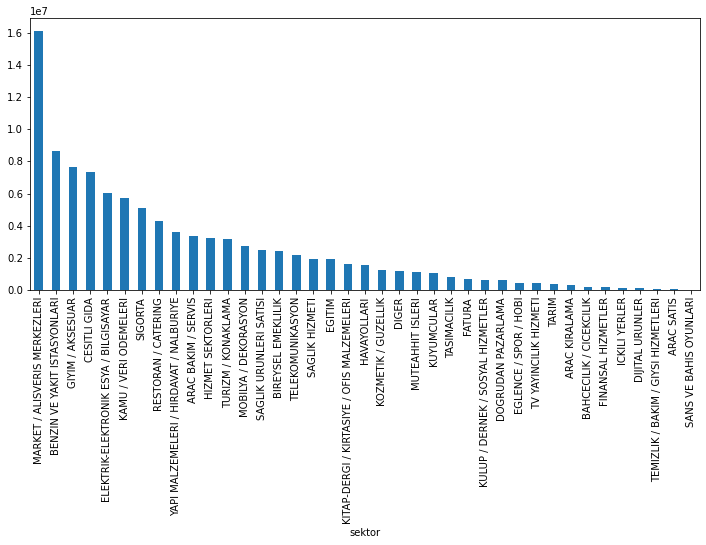

In [63]:
train[train.yil==2019].groupby("sektor")["islem_tutari"].sum().sort_values(ascending=False).plot.bar(figsize=(12,5));

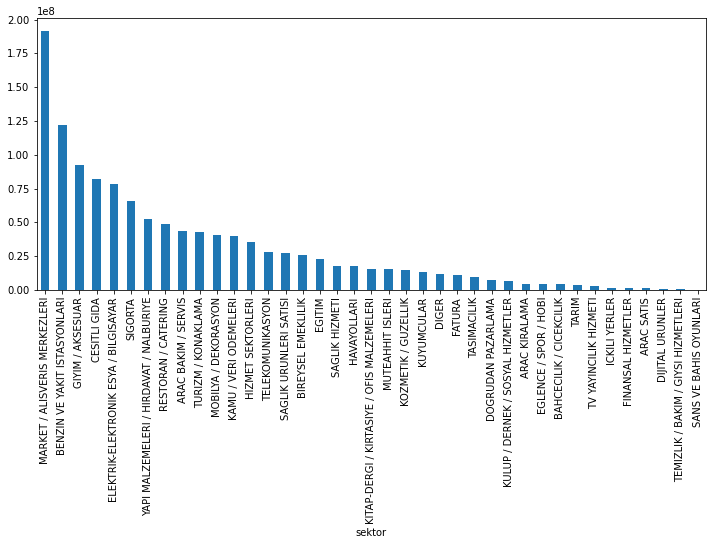

In [64]:
train[train.yil==2018].groupby("sektor")["islem_tutari"].sum().sort_values(ascending=False).plot.bar(figsize=(12,5));

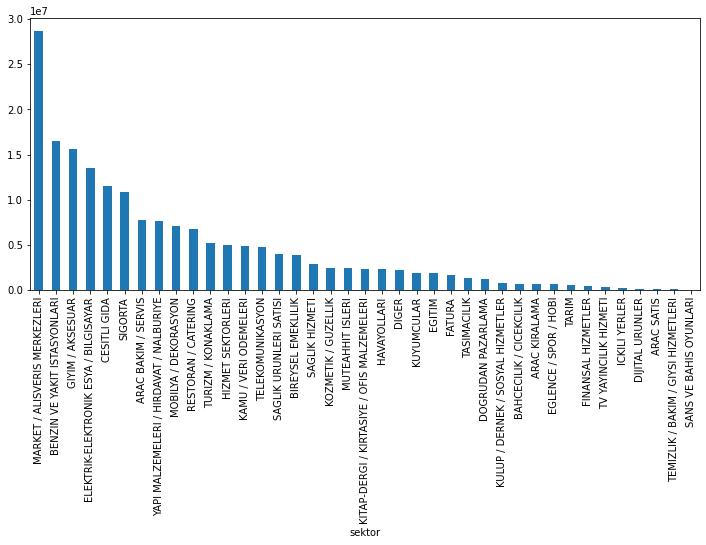

In [65]:
train[train.yil==2017].groupby("sektor")["islem_tutari"].sum().sort_values(ascending=False).plot.bar(figsize=(12,5));

In [16]:
def fix_date(train,test):
    train.yil_ay=train.yil_ay.astype(str)
    test.yil_ay=test.yil_ay.astype(str)
    train["date"]=[train.yil_ay[i][:4]+"-"+train.yil_ay[i][4:] for i in range(len(train.yil_ay))]
    test["date"]=[test.yil_ay[i][:4]+"-"+test.yil_ay[i][4:] for i in range(len(test.yil_ay))]
    train["date"]=pd.to_datetime(train.date)
    test["date"]=pd.to_datetime(test.date)

fix_date(train,test)

In [17]:
def extract_from_date(data):
    data["ay"]=data.date.dt.month
    data["yil"]=data.date.dt.year
    data["week"]=data.date.dt.week
    data["quarter"]=data.date.dt.quarter
    
    data['semester'] = np.where(data['quarter'].isin([1,2]), 1, 2)

extract_from_date(train)
extract_from_date(test)

In [18]:
train[train.islem_tutari.eq(0)].index

Int64Index([975422, 2255607, 2618141, 2912355, 3216139], dtype='int64')

In [19]:
train=train.drop([975422, 2255607, 2618141, 2912355, 3216139])

In [20]:
train.head()

,islem_tutari,islem_adedi,islem_turu,yil_ay,sektor,record_count,customer,id,dolar,tufe_aylik,tufe_yillik,tatil_sayi,date,ay,yil,week,quarter,semester
0,279.94,2.0,PESIN,201711,GIYIM / AKSESUAR,19,219,15,3.88,1.49,12.98,8.0,2017-11-01,11,2017,44,4,2
1,180.50,13.0,PESIN,201711,CESITLI GIDA,19,219,6,3.88,1.49,12.98,8.0,2017-11-01,11,2017,44,4,2
2,141.50,2.0,PESIN,201711,SAGLIK URUNLERI SATISI,19,219,29,3.88,1.49,12.98,8.0,2017-11-01,11,2017,44,4,2
3,138.18,4.0,PESIN,201711,ELEKTRIK-ELEKTRONIK ESYA / BILGISAYAR,19,219,12,3.88,1.49,12.98,8.0,2017-11-01,11,2017,44,4,2
4,301.49,8.0,PESIN,201711,MARKET / ALISVERIS MERKEZLERI,19,219,24,3.88,1.49,12.98,8.0,2017-11-01,11,2017,44,4,2


In [21]:
test.head()

,islem_tutari,islem_adedi,islem_turu,yil_ay,sektor,record_count,customer,id,dolar,tufe_aylik,tufe_yillik,tatil_sayi,date,ay,yil,week,quarter,semester
0,NaN,2.0,PESIN,201902,ELEKTRIK-ELEKTRONIK ESYA / BILGISAYAR,19,1,12,5.26,0.16,19.67,8.0,2019-02-01,2,2019,5,1,1
1,NaN,21.0,PESIN,201902,RESTORAN / CATERING,19,1,27,5.26,0.16,19.67,8.0,2019-02-01,2,2019,5,1,1
2,NaN,4.0,PESIN,201902,KOZMETIK / GUZELLIK,19,1,21,5.26,0.16,19.67,8.0,2019-02-01,2,2019,5,1,1
3,NaN,7.0,PESIN,201902,TASIMACILIK,19,1,33,5.26,0.16,19.67,8.0,2019-02-01,2,2019,5,1,1
4,NaN,2.0,PESIN,201902,TV YAYINCILIK HIZMETI,19,1,37,5.26,0.16,19.67,8.0,2019-02-01,2,2019,5,1,1


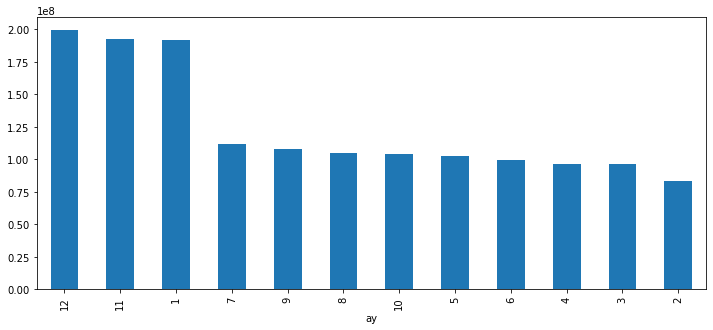

In [67]:
train.groupby("ay")["islem_tutari"].sum().sort_values(ascending=False).plot.bar(figsize=(12,5));

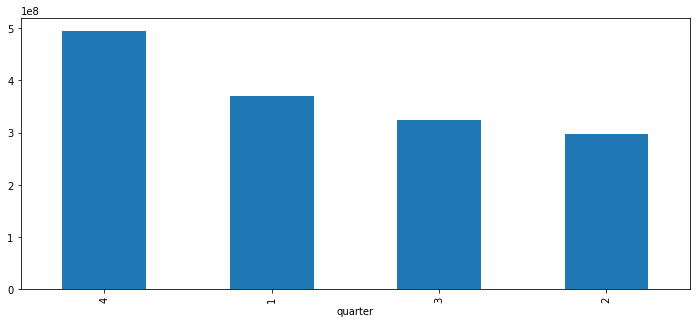

In [68]:
train.groupby("quarter")["islem_tutari"].sum().sort_values(ascending=False).plot.bar(figsize=(12,5));

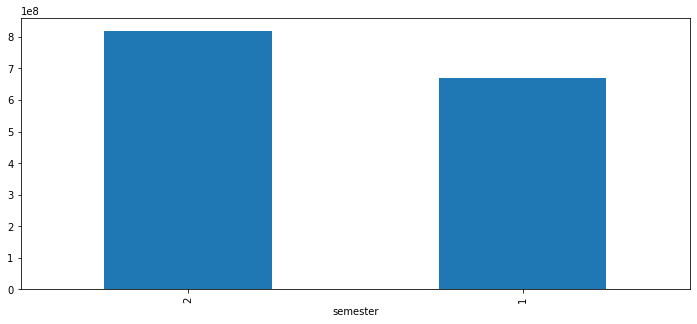

In [69]:
train.groupby("semester")["islem_tutari"].sum().sort_values(ascending=False).plot.bar(figsize=(12,5));

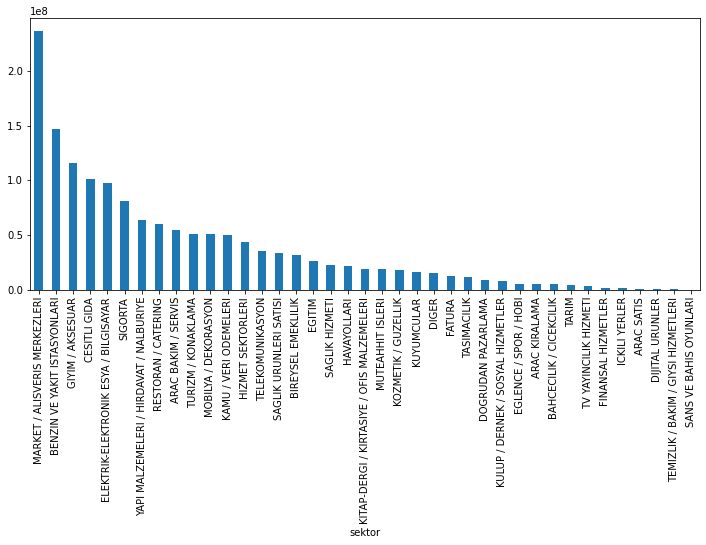

In [70]:
train.groupby("sektor")["islem_tutari"].sum().sort_values(ascending=False).plot.bar(figsize=(12,5));

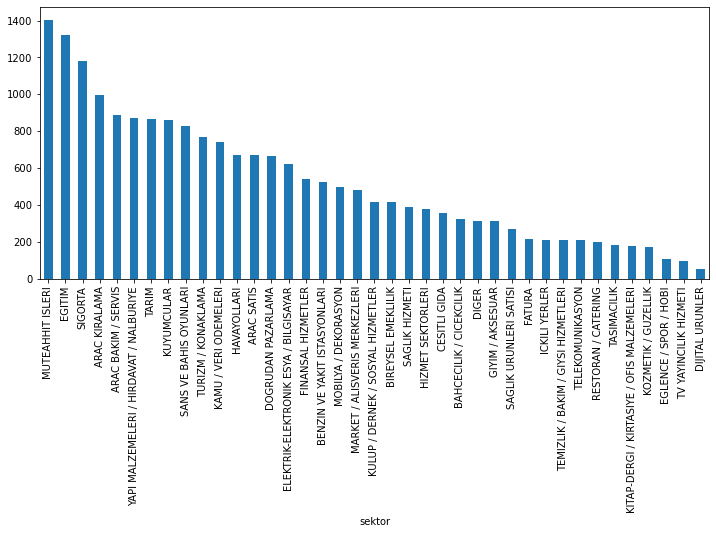

In [74]:
train.groupby("sektor")["islem_tutari"].mean().sort_values(ascending=False).plot.bar(figsize=(12,5));

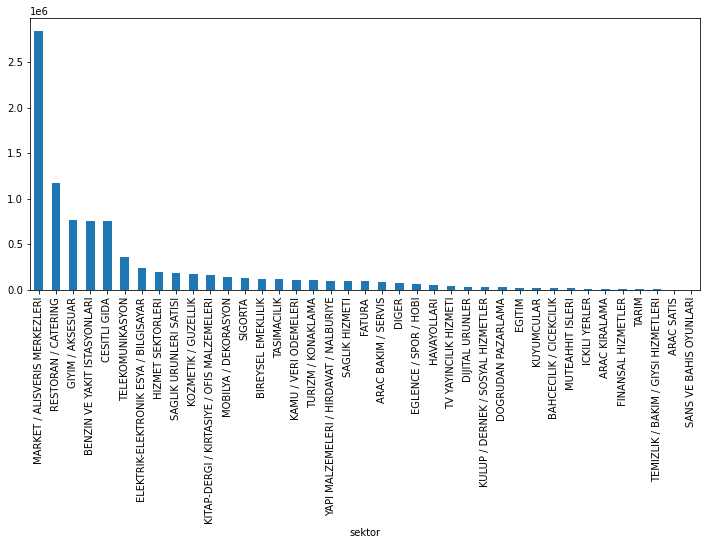

In [82]:
train.groupby("sektor")["islem_adedi"].sum().sort_values(ascending=False).plot.bar(figsize=(12,5));

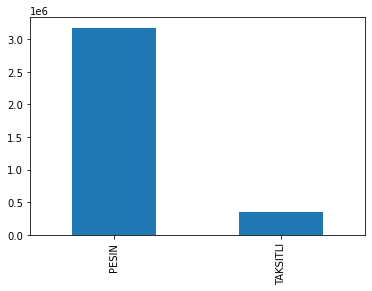

In [79]:
train.islem_turu.value_counts().plot.bar();

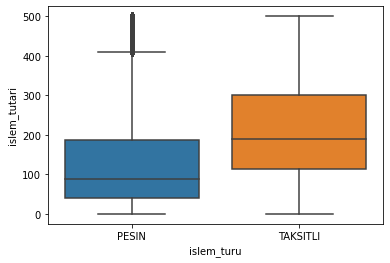

In [81]:
sns.boxplot(x="islem_turu",y="islem_tutari",data=train[train.islem_tutari<500]);

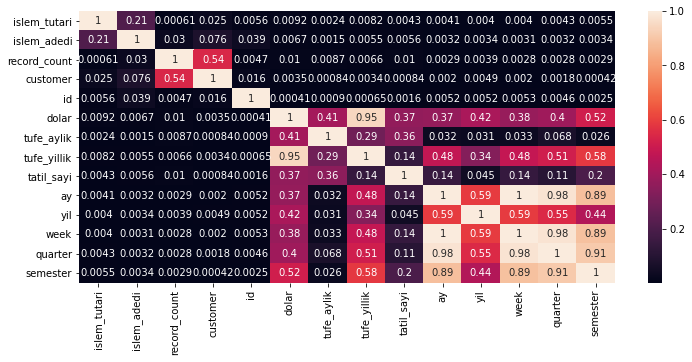

In [83]:
plt.figure(figsize=(12,5));
sns.heatmap(train.corr().abs(),annot=True);

In [84]:
stats.describe(train.islem_tutari)

DescribeResult(nobs=3526229, minmax=(0.01, 500000.0), mean=421.9129537162793, variance=5442472.667252829, skewness=61.11105422989861, kurtosis=7323.052531321608)

In [85]:
stats.describe(train.islem_adedi)

DescribeResult(nobs=3526229, minmax=(0.0, 2132.0), mean=2.6121703950594246, variance=33.111703366938755, skewness=119.8776235752487, kurtosis=28557.862991789054)

In [22]:
train_df=train.copy()
test_df=test.copy()

In [23]:
customer_mean=pd.DataFrame(train_df.groupby("customer")["islem_tutari"].mean())
train_df=pd.merge(train_df,customer_mean,how="inner",on="customer").rename({"islem_tutari_x":"islem_tutari","islem_tutari_y":"customer_mean"},axis=1)
test_df=pd.merge(test_df,customer_mean,how="inner",on="customer").rename({"islem_tutari_x":"islem_tutari","islem_tutari_y":"customer_mean"},axis=1)

In [24]:
customer_islem_mean=train_df.groupby("customer")["islem_adedi"].mean()
train_df=pd.merge(train_df,customer_islem_mean,how="inner",on=["customer"]).rename({"islem_adedi_x":"islem_adedi","islem_adedi_y":"customer_islem_mean"},axis=1)
test_df=pd.merge(test_df,customer_islem_mean,how="inner",on=["customer"]).rename({"islem_adedi_x":"islem_adedi","islem_adedi_y":"customer_islem_mean"},axis=1)

In [25]:
train_df["per_islem_mean"]=train_df["customer_mean"]/train_df["customer_islem_mean"]
test_df["per_islem_mean"]=test_df["customer_mean"]/test_df["customer_islem_mean"]

In [26]:
sek_ay_mean=train_df.groupby(["sektor","ay"])["islem_tutari"].mean()
train_df=pd.merge(train_df,sek_ay_mean,how="inner",on=["sektor","ay"]).rename({"islem_tutari_x":"islem_tutari","islem_tutari_y":"sek_ay_mean"},axis=1)
test_df=pd.merge(test_df,sek_ay_mean,how="inner",on=["sektor","ay"]).rename({"islem_tutari_x":"islem_tutari","islem_tutari_y":"sek_ay_mean"},axis=1)

In [27]:
count_map=train_df.customer.value_counts().to_dict()
train_df["count_customer"]=train_df.customer.map(count_map)
test_df["count_customer"]=test_df.customer.map(count_map)

In [28]:
sek_is_mean=train_df.groupby(["sektor","islem_turu"])["islem_tutari"].mean()
train_df=pd.merge(train_df,sek_is_mean,how="inner",on=["sektor","islem_turu"]).rename({"islem_tutari_x":"islem_tutari","islem_tutari_y":"sek_is_mean"},axis=1)
test_df=pd.merge(test_df,sek_is_mean,how="inner",on=["sektor","islem_turu"]).rename({"islem_tutari_x":"islem_tutari","islem_tutari_y":"sek_is_mean"},axis=1)

In [29]:
adet_sek_mean=train_df.groupby(["sektor","islem_adedi"])["islem_tutari"].mean()
train_df=pd.merge(train_df,adet_sek_mean,how="inner",on=["sektor","islem_adedi"]).rename({"islem_tutari_x":"islem_tutari","islem_tutari_y":"adet_sek_mean"},axis=1)
test_df=pd.merge(test_df,adet_sek_mean,how="inner",on=["sektor","islem_adedi"]).rename({"islem_tutari_x":"islem_tutari","islem_tutari_y":"adet_sek_mean"},axis=1)

In [30]:
train_df["sek_per_mean"]=train_df["sek_is_mean"]/train_df["adet_sek_mean"]
test_df["sek_per_mean"]=test_df["sek_is_mean"]/test_df["adet_sek_mean"]

In [31]:
sek_adet_tur_mean=train_df.groupby(["sektor","islem_adedi","islem_turu"])["islem_tutari"].mean()
train_df=pd.merge(train_df,sek_adet_tur_mean,how="inner",on=["sektor","islem_adedi","islem_turu"]).rename({"islem_tutari_x":"islem_tutari","islem_tutari_y":"sek_adet_tur_mean"},axis=1)
test_df=pd.merge(test_df,sek_adet_tur_mean,how="inner",on=["sektor","islem_adedi","islem_turu"]).rename({"islem_tutari_x":"islem_tutari","islem_tutari_y":"sek_adet_tur_mean"},axis=1)

In [32]:
tur_customer_mean=train_df.groupby(["islem_turu","customer"])["islem_tutari"].mean()
train_df=pd.merge(train_df,tur_customer_mean,how="inner",on=["islem_turu","customer"]).rename({"islem_tutari_x":"islem_tutari","islem_tutari_y":"tur_customer_mean"},axis=1)
test_df=pd.merge(test_df,tur_customer_mean,how="inner",on=["islem_turu","customer"]).rename({"islem_tutari_x":"islem_tutari","islem_tutari_y":"tur_customer_mean"},axis=1)

In [33]:
count_map_=train_df.sektor.value_counts().to_dict()
train_df["count_sektor"]=train_df.sektor.map(count_map_)
test_df["count_sektor"]=test_df.sektor.map(count_map_)

In [35]:
min_islem_tutari=train_df.groupby(["customer"])["islem_tutari"].min()
max_islem_tutari=train_df.groupby("customer")["islem_tutari"].max()
toplam_islem_tutari=train_df.groupby("customer")["islem_tutari"].sum()

In [36]:
train_df=pd.merge(train_df,min_islem_tutari,how="inner",on=["customer"]).rename({"islem_tutari_x":"islem_tutari","islem_tutari_y":"min_tutar"},axis=1)##
test_df=pd.merge(test_df,min_islem_tutari,how="inner",on=["customer"]).rename({"islem_tutari_x":"islem_tutari","islem_tutari_y":"min_tutar"},axis=1)

train_df=pd.merge(train_df,max_islem_tutari,how="inner",on=["customer"]).rename({"islem_tutari_x":"islem_tutari","islem_tutari_y":"max_tutar"},axis=1)
test_df=pd.merge(test_df,max_islem_tutari,how="inner",on=["customer"]).rename({"islem_tutari_x":"islem_tutari","islem_tutari_y":"max_tutar"},axis=1)

train_df=pd.merge(train_df,toplam_islem_tutari,how="inner",on=["customer"]).rename({"islem_tutari_x":"islem_tutari","islem_tutari_y":"toplam_tutar"},axis=1)
test_df=pd.merge(test_df,toplam_islem_tutari,how="inner",on=["customer"]).rename({"islem_tutari_x":"islem_tutari","islem_tutari_y":"toplam_tutar"},axis=1)

In [37]:
sektor_mean=train_df.groupby("sektor")["islem_tutari"].mean()
train_df=pd.merge(train_df,sektor_mean,how="inner",on=["sektor"]).rename({"islem_tutari_x":"islem_tutari","islem_tutari_y":"sektor_mean"},axis=1)
test_df=pd.merge(test_df,sektor_mean,how="inner",on=["sektor"]).rename({"islem_tutari_x":"islem_tutari","islem_tutari_y":"sektor_mean"},axis=1)

In [38]:
train_df["oran_sek_cus"]=train_df["customer_mean"]/train_df["sektor_mean"]
test_df["oran_sek_cus"]=test_df["customer_mean"]/test_df["sektor_mean"]

In [39]:
max_sektor_tutar=train_df.groupby(["sektor"])["islem_tutari"].max()
train_df=pd.merge(train_df,max_sektor_tutar,how="inner",on=["sektor"]).rename({"islem_tutari_x":"islem_tutari","islem_tutari_y":"max_sektor_tutar"},axis=1)
test_df=pd.merge(test_df,max_sektor_tutar,how="inner",on=["sektor"]).rename({"islem_tutari_x":"islem_tutari","islem_tutari_y":"max_sektor_tutar"},axis=1)

In [40]:
train_df.head()

,islem_tutari,islem_adedi,islem_turu,yil_ay,sektor,record_count,customer,id,dolar,tufe_aylik,tufe_yillik,tatil_sayi,date,ay,yil,week,quarter,semester,customer_mean,customer_islem_mean,per_islem_mean,sek_ay_mean,count_customer,sek_is_mean,adet_sek_mean,sek_per_mean,sek_adet_tur_mean,tur_customer_mean,count_sektor,id_tutar_mean,min_tutar,max_tutar,toplam_tutar,sektor_mean,oran_sek_cus,max_sektor_tutar
0,279.94,2.0,PESIN,201711,GIYIM / AKSESUAR,19,219,15,3.88,1.49,12.98,8.0,2017-11-01,11,2017,44,4,2,376.575399,3.131455,120.255712,339.913726,213,260.571485,303.659405,0.858104,223.677698,246.895808,370496,311.879342,1.0,2643.8,80210.56,312.641632,1.204495,106907.19
1,372.59,2.0,PESIN,201807,GIYIM / AKSESUAR,19,219,15,4.75,0.55,15.85,9.0,2018-07-01,7,2018,26,3,2,376.575399,3.131455,120.255712,299.490570,213,260.571485,303.659405,0.858104,223.677698,246.895808,370496,311.879342,1.0,2643.8,80210.56,312.641632,1.204495,106907.19
2,174.94,1.0,PESIN,201811,GIYIM / AKSESUAR,19,219,15,5.37,-1.44,21.62,8.0,2018-11-01,11,2018,44,4,2,376.575399,3.131455,120.255712,339.913726,213,260.571485,180.020127,1.447458,129.167429,246.895808,370496,311.879342,1.0,2643.8,80210.56,312.641632,1.204495,106907.19
3,125.96,1.0,PESIN,201812,GIYIM / AKSESUAR,19,219,15,5.31,-0.40,20.30,10.0,2018-12-01,12,2018,48,4,2,376.575399,3.131455,120.255712,327.296339,213,260.571485,180.020127,1.447458,129.167429,246.895808,370496,311.879342,1.0,2643.8,80210.56,312.641632,1.204495,106907.19
4,368.00,1.0,PESIN,201801,GIYIM / AKSESUAR,19,219,15,3.77,1.02,10.35,9.0,2018-01-01,1,2018,1,1,1,376.575399,3.131455,120.255712,313.808422,213,260.571485,180.020127,1.447458,129.167429,246.895808,370496,311.879342,1.0,2643.8,80210.56,312.641632,1.204495,106907.19


In [41]:
columns=["islem_tutari","sek_is_mean","sek_adet_tur_mean","sek_per_mean","tur_customer_mean","toplam_tutar","islem_adedi",
         "islem_turu","sektor","dolar","tufe_aylik","customer_islem_mean","ay","yil","tatil_sayi",
         "count_customer","count_sektor","sektor_mean","max_sektor_tutar"]

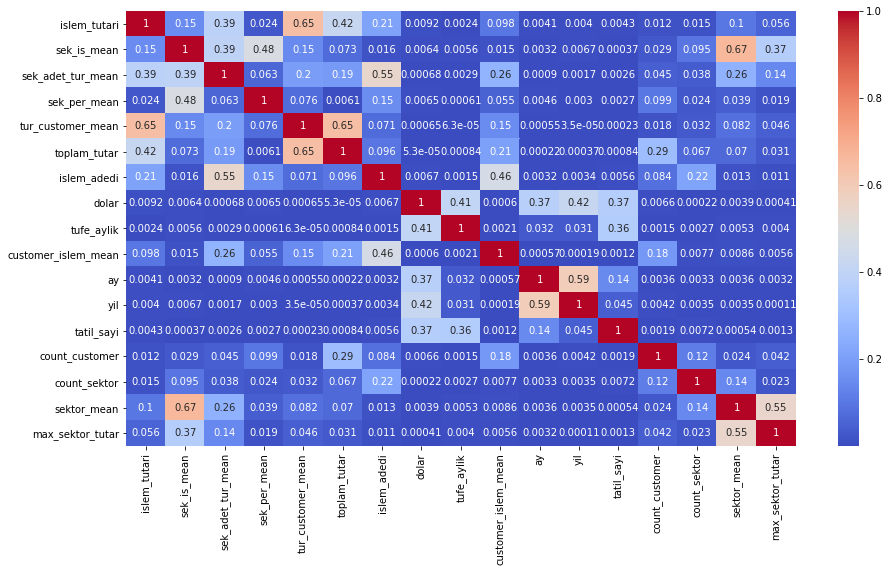

In [42]:
plt.figure(figsize=(15,8));
sns.heatmap(train_df[columns].corr().abs(),annot=True,cmap="coolwarm");

In [44]:
columns=["sek_is_mean","sek_adet_tur_mean","sek_per_mean","tur_customer_mean","toplam_tutar","islem_adedi",
         "islem_turu","sektor","dolar","tufe_aylik","customer_islem_mean","ay","yil","tatil_sayi",
         "count_customer","count_sektor","sektor_mean"]

In [45]:
X_train=train_df[columns]
X_test=test_df[columns]
y_train=train_df["islem_tutari"]

In [46]:
X_train.head()

,sek_is_mean,sek_adet_tur_mean,sek_per_mean,tur_customer_mean,toplam_tutar,islem_adedi,islem_turu,sektor,dolar,tufe_aylik,customer_islem_mean,ay,yil,tatil_sayi,count_customer,count_sektor,sektor_mean
0,260.571485,223.677698,0.858104,246.895808,80210.56,2.0,PESIN,GIYIM / AKSESUAR,3.88,1.49,3.131455,11,2017,8.0,213,370496,312.641632
1,260.571485,223.677698,0.858104,246.895808,80210.56,2.0,PESIN,GIYIM / AKSESUAR,4.75,0.55,3.131455,7,2018,9.0,213,370496,312.641632
2,260.571485,129.167429,1.447458,246.895808,80210.56,1.0,PESIN,GIYIM / AKSESUAR,5.37,-1.44,3.131455,11,2018,8.0,213,370496,312.641632
3,260.571485,129.167429,1.447458,246.895808,80210.56,1.0,PESIN,GIYIM / AKSESUAR,5.31,-0.40,3.131455,12,2018,10.0,213,370496,312.641632
4,260.571485,129.167429,1.447458,246.895808,80210.56,1.0,PESIN,GIYIM / AKSESUAR,3.77,1.02,3.131455,1,2018,9.0,213,370496,312.641632


In [49]:
X_train_encoded=pd.get_dummies(X_train)
X_test_encoded=pd.get_dummies(X_test)

In [50]:
X_train_encoded.head()

,sek_is_mean,sek_adet_tur_mean,sek_per_mean,tur_customer_mean,toplam_tutar,islem_adedi,dolar,tufe_aylik,customer_islem_mean,ay,yil,tatil_sayi,count_customer,count_sektor,sektor_mean,islem_turu_PESIN,islem_turu_TAKSITLI,sektor_ARAC BAKIM / SERVIS,sektor_ARAC KIRALAMA,sektor_ARAC SATIS,sektor_BAHCECILIK / CICEKCILIK,sektor_BENZIN VE YAKIT ISTASYONLARI,sektor_BIREYSEL EMEKLILIK,sektor_CESITLI GIDA,sektor_DIGER,sektor_DIJITAL URUNLER,sektor_DOGRUDAN PAZARLAMA,sektor_EGITIM,sektor_EGLENCE / SPOR / HOBI,sektor_ELEKTRIK-ELEKTRONIK ESYA / BILGISAYAR,sektor_FATURA,sektor_FINANSAL HIZMETLER,sektor_GIYIM / AKSESUAR,sektor_HAVAYOLLARI,sektor_HIZMET SEKTORLERI,sektor_ICKILI YERLER,sektor_KAMU / VERI ODEMELERI,sektor_KITAP-DERGI / KIRTASIYE / OFIS MALZEMELERI,sektor_KOZMETIK / GUZELLIK,sektor_KULUP / DERNEK / SOSYAL HIZMETLER,sektor_KUYUMCULAR,sektor_MARKET / ALISVERIS MERKEZLERI,sektor_MOBILYA / DEKORASYON,sektor_MUTEAHHIT ISLERI,sektor_RESTORAN / CATERING,sektor_SAGLIK HIZMETI,sektor_SAGLIK URUNLERI SATISI,sektor_SANS VE BAHIS OYUNLARI,sektor_SIGORTA,sektor_TARIM,sektor_TASIMACILIK,sektor_TELEKOMUNIKASYON,sektor_TEMIZLIK / BAKIM / GIYSI HIZMETLERI,sektor_TURIZM / KONAKLAMA,sektor_TV YAYINCILIK HIZMETI,sektor_YAPI MALZEMELERI / HIRDAVAT / NALBURIYE
0,260.571485,223.677698,0.858104,246.895808,80210.56,2.0,3.88,1.49,3.131455,11,2017,8.0,213,370496,312.641632,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,260.571485,223.677698,0.858104,246.895808,80210.56,2.0,4.75,0.55,3.131455,7,2018,9.0,213,370496,312.641632,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,260.571485,129.167429,1.447458,246.895808,80210.56,1.0,5.37,-1.44,3.131455,11,2018,8.0,213,370496,312.641632,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,260.571485,129.167429,1.447458,246.895808,80210.56,1.0,5.31,-0.40,3.131455,12,2018,10.0,213,370496,312.641632,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,260.571485,129.167429,1.447458,246.895808,80210.56,1.0,3.77,1.02,3.131455,1,2018,9.0,213,370496,312.641632,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [51]:
X_test_encoded.head()

,sek_is_mean,sek_adet_tur_mean,sek_per_mean,tur_customer_mean,toplam_tutar,islem_adedi,dolar,tufe_aylik,customer_islem_mean,ay,yil,tatil_sayi,count_customer,count_sektor,sektor_mean,islem_turu_PESIN,islem_turu_TAKSITLI,sektor_ARAC BAKIM / SERVIS,sektor_ARAC KIRALAMA,sektor_ARAC SATIS,sektor_BAHCECILIK / CICEKCILIK,sektor_BENZIN VE YAKIT ISTASYONLARI,sektor_BIREYSEL EMEKLILIK,sektor_CESITLI GIDA,sektor_DIGER,sektor_DIJITAL URUNLER,sektor_DOGRUDAN PAZARLAMA,sektor_EGITIM,sektor_EGLENCE / SPOR / HOBI,sektor_ELEKTRIK-ELEKTRONIK ESYA / BILGISAYAR,sektor_FATURA,sektor_FINANSAL HIZMETLER,sektor_GIYIM / AKSESUAR,sektor_HAVAYOLLARI,sektor_HIZMET SEKTORLERI,sektor_ICKILI YERLER,sektor_KAMU / VERI ODEMELERI,sektor_KITAP-DERGI / KIRTASIYE / OFIS MALZEMELERI,sektor_KOZMETIK / GUZELLIK,sektor_KULUP / DERNEK / SOSYAL HIZMETLER,sektor_KUYUMCULAR,sektor_MARKET / ALISVERIS MERKEZLERI,sektor_MOBILYA / DEKORASYON,sektor_MUTEAHHIT ISLERI,sektor_RESTORAN / CATERING,sektor_SAGLIK HIZMETI,sektor_SAGLIK URUNLERI SATISI,sektor_SANS VE BAHIS OYUNLARI,sektor_SIGORTA,sektor_TARIM,sektor_TASIMACILIK,sektor_TELEKOMUNIKASYON,sektor_TEMIZLIK / BAKIM / GIYSI HIZMETLERI,sektor_TURIZM / KONAKLAMA,sektor_TV YAYINCILIK HIZMETI,sektor_YAPI MALZEMELERI / HIRDAVAT / NALBURIYE
0,426.073596,529.602783,0.564748,554.372138,181063.07,2.0,5.26,0.16,4.308869,2,2019,8.0,327,157074,623.39263,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,426.073596,529.602783,0.564748,1530.745502,535874.39,2.0,5.26,0.16,5.452381,2,2019,8.0,336,157074,623.39263,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,426.073596,529.602783,0.564748,334.919921,107883.92,2.0,5.26,0.16,3.338028,2,2019,8.0,284,157074,623.39263,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,426.073596,529.602783,0.564748,436.108273,134683.31,2.0,5.26,0.16,2.890459,2,2019,8.0,283,157074,623.39263,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,426.073596,529.602783,0.564748,782.710650,243317.35,2.0,5.26,0.16,3.201413,2,2019,8.0,283,157074,623.39263,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [52]:
X_train_encoded.shape,X_test_encoded.shape

((3526229, 56), (219341, 56))

In [53]:
scaler=RobustScaler()
X_train_scaled=scaler.fit_transform(X_train_encoded)
X_test_scaled=scaler.transform(X_test_encoded)

In [54]:
model=LGBMRegressor(n_estimators=4000,
                    reg_alpha=0.05,
                    max_depth=9,
                    lambda_l1=0.1,
                    lambda_l2=0.09,
                    learning_rate=0.1)

model_fitted=model.fit(X_train_scaled,y_train)  



In [55]:
model_fitted.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': 9,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 4000,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.05,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'lambda_l1': 0.1,
 'lambda_l2': 0.09}

In [86]:
#model.score(X_train_scaled,y_train)

In [57]:
y_pred=model_fitted.predict(X_test_scaled)

In [58]:
submission["Expected"]=pd.DataFrame({"id":test_df.id,"pred":y_pred}).groupby("id")["pred"].sum()
submission

,Sektor_Id,Expected
0,0,3.175780e+06
1,1,2.492739e+05
2,2,2.905242e+04
3,3,5.664899e+05
4,4,9.066232e+06
5,5,2.229678e+06
6,6,6.935490e+06
7,7,1.054038e+06
8,8,1.268301e+05
9,9,5.947254e+05


In [60]:
def plot_imp(model):
    model.importance_type="split"
    feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_train_encoded.columns)), columns=['Value','Feature'])
    plt.figure(figsize=(18,12));
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False));
    plt.title("Feature Importance (Split)")
    plt.show()
   # plot_importance(booster=model,figsize=(20,10),height=0.5,importance_type="gain");
    model.importance_type="gain"
    feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_train_encoded.columns)), columns=['Value','Feature'])
    plt.figure(figsize=(18,12));
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False));
    plt.title("Feature Importance (Gain)")
    plt.show()

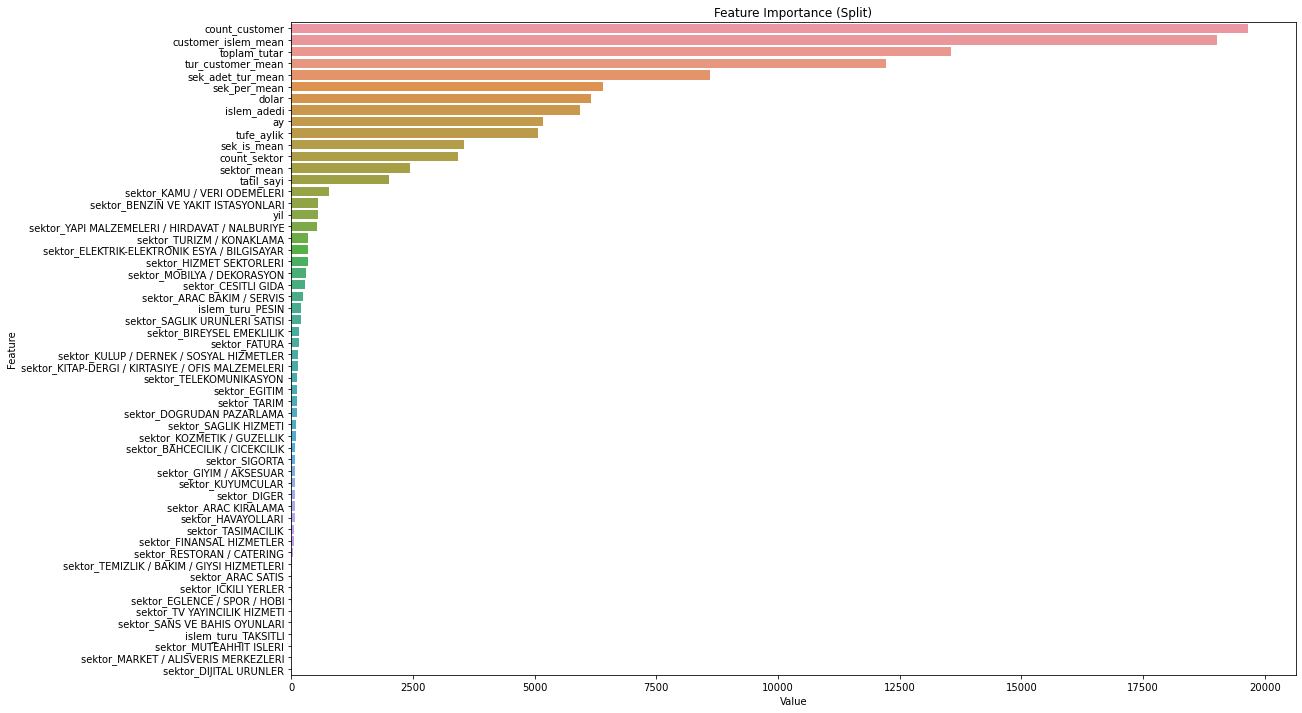

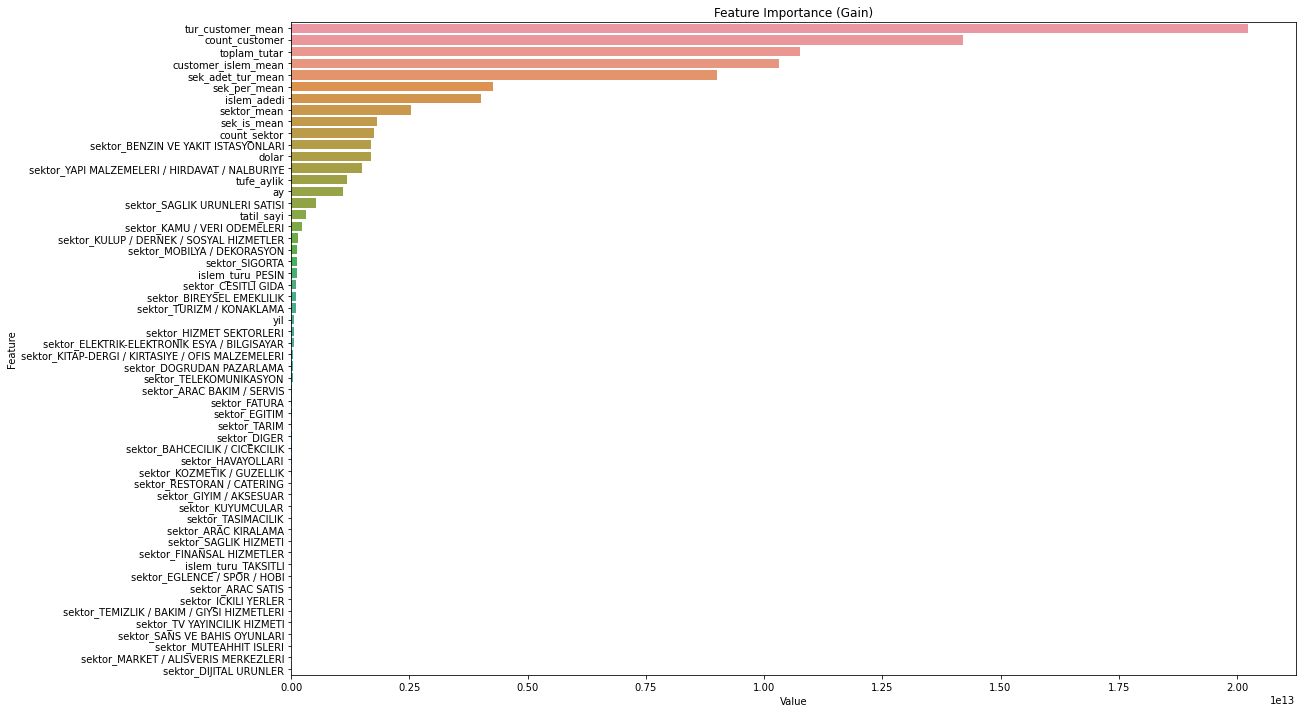

In [61]:
plot_imp(model)

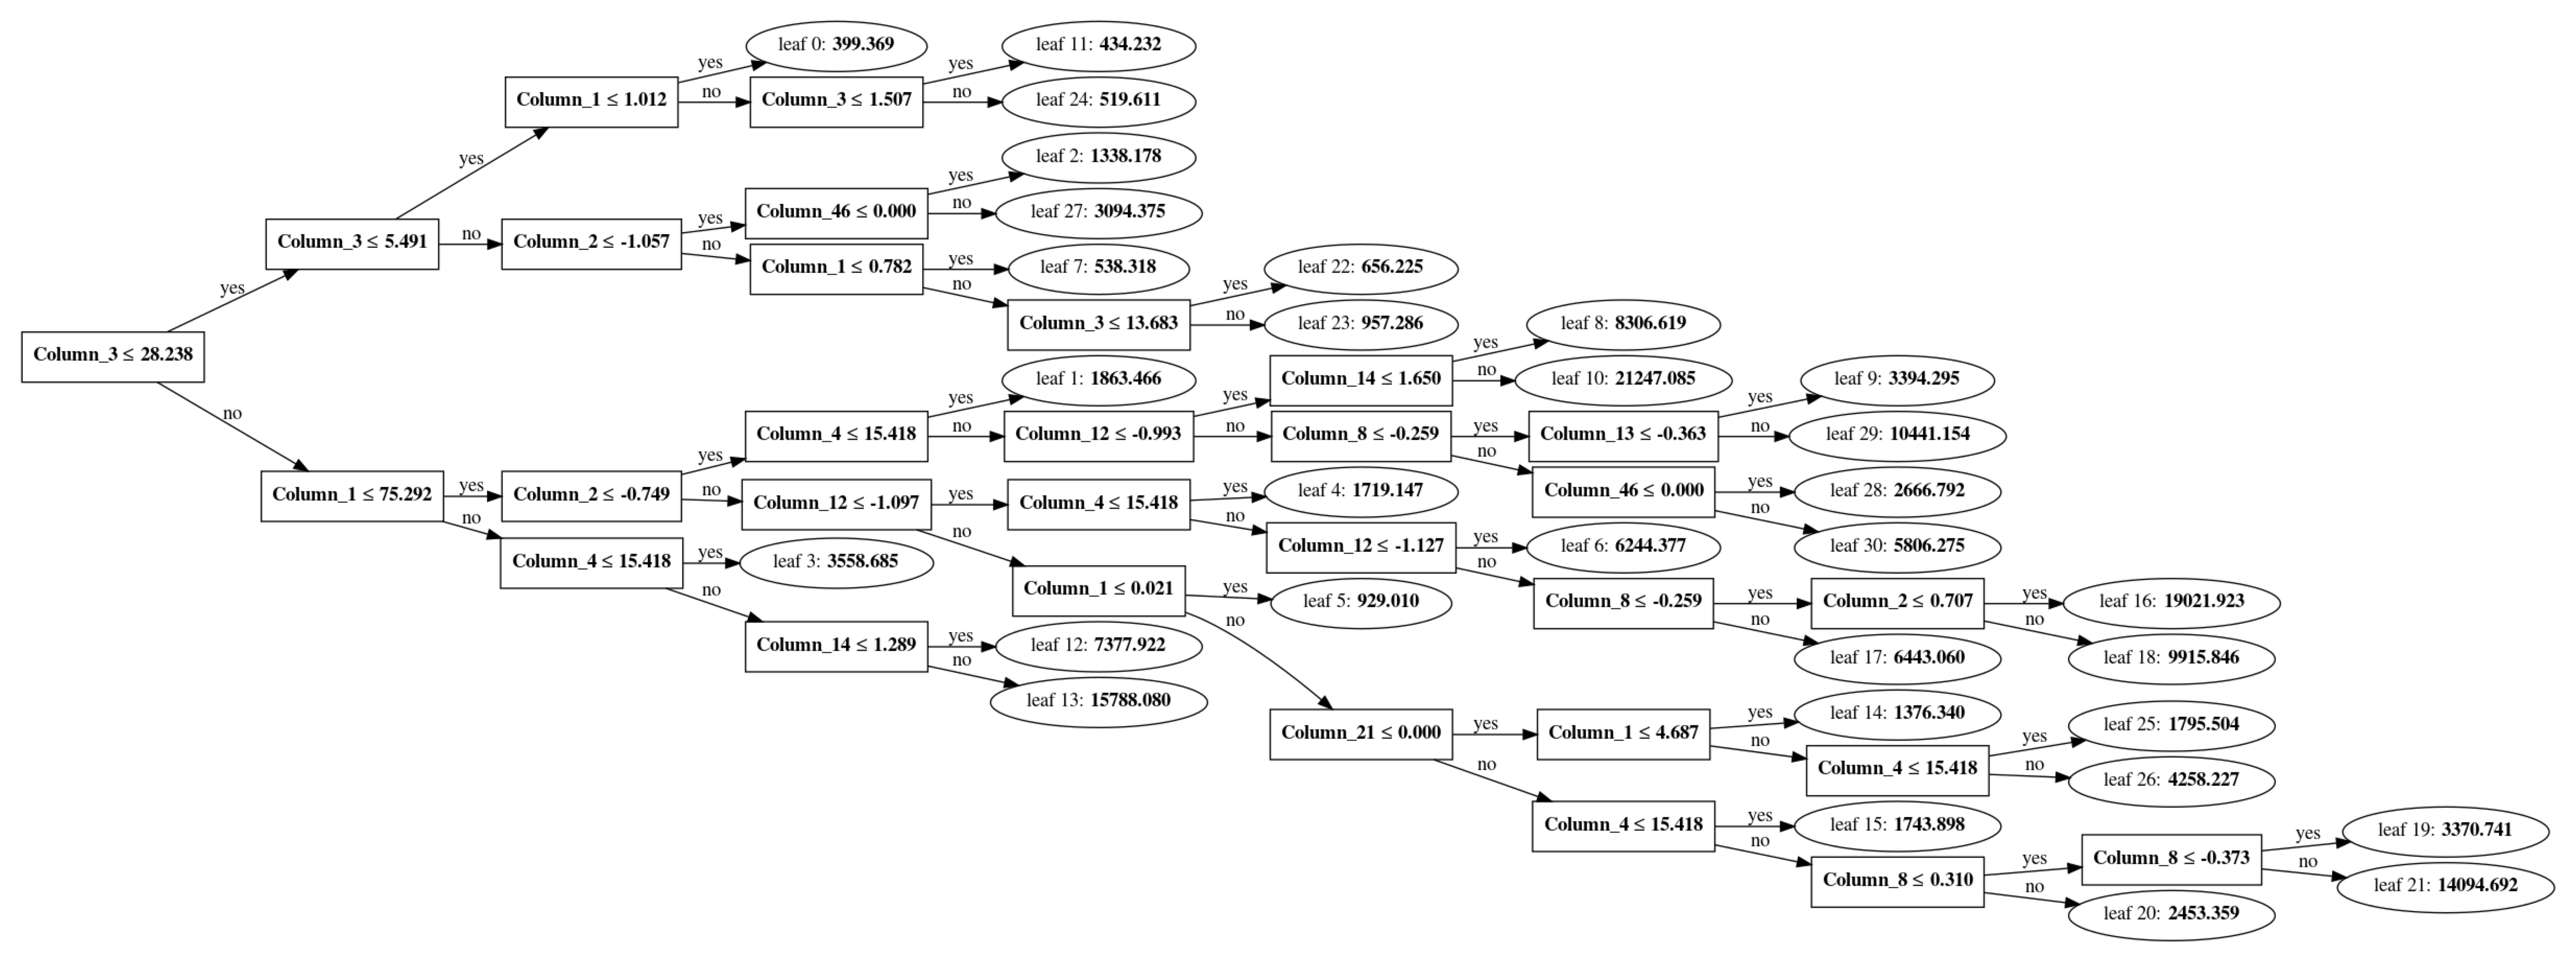

In [62]:
plot_tree(model,figsize=(20,15),dpi=300);

In [59]:
submission_csv=submission.to_csv("submission.csv",index=False)
from IPython.display import FileLink
FileLink(r'submission.csv')

/kaggle/working/submission.csv